In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from functools import partial, reduce
from numpy.linalg import inv
from scipy.stats import lognorm
import pylab
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from copy import copy

%matplotlib inline

# Least squares

Задаем преобразование признаков

In [2]:
def polynom(i, x):
    return x**i

Генерируем матрицу объекты-признаки

In [3]:
degree = 5
def make_poly_features(fun, X, i=degree):
    features = [fun(i, X) for i in range(i)]
    features = np.array(features).T
    return features

Получаем веса

In [4]:
#features = make_poly_features(polynom, X)
def get_weights(features, y):
    return inv(features.T@features)@features.T@y

Генерируем признаки

In [5]:
# s = 0.54
# mean, var, skew, kurt = lognorm.stats(s, moments='mvsk')

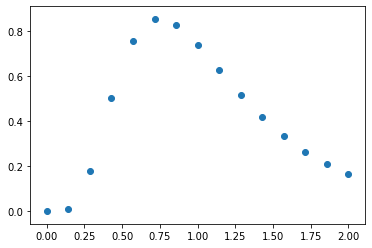

In [6]:
s = 0.54
X = np.linspace(0, 2, 15)
Y = lognorm.pdf(X, s)
plt.scatter(X, Y)

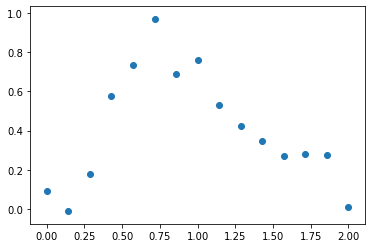

In [7]:
Y_new =[]
for i, val in enumerate(Y):
    Y_new.append(val + np.random.normal(scale = 0.07))
plt.scatter(X, Y_new)

In [8]:
def fitted_func(W, x, degree=degree):
    _sum = 0
    for i in range(degree):
        _sum += W[i]*(pow(x, i))
    return _sum

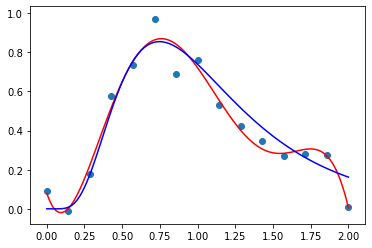

In [9]:
degree=6
X_test = np.linspace(0, 2, 100)
W = get_weights(make_poly_features(polynom, X, degree), Y_new)
pylab.scatter(X, Y_new)
pylab.plot(X_test, fitted_func(W, X_test, degree), c='red')
pylab.plot(X_test, lognorm.pdf(X_test, s), c='blue')
pylab.show()

# Overfitting

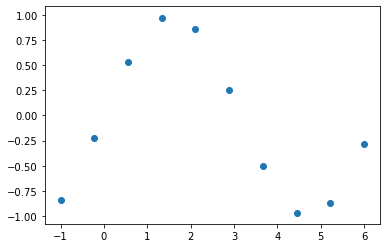

In [10]:
X_of = np.linspace(-1, 6, 10)
Y_of = np.sin(X_of)
plt.scatter(X_of, Y_of)

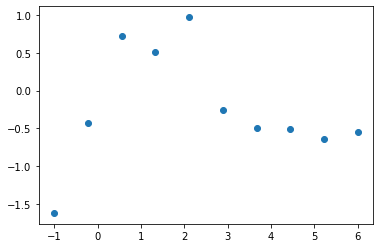

In [11]:
Y_new_of =[]
for i, val in enumerate(Y_of):
    Y_new_of.append(val + np.random.normal(scale = 0.3))
plt.scatter(X_of, Y_new_of)

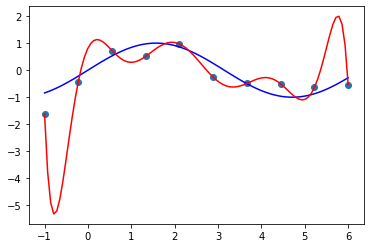

In [12]:
degree = 10
X_test_of = np.linspace(-1, 6, 100)
W_of = get_weights(make_poly_features(polynom, X_of, degree), Y_new_of)
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of), c='blue')
pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='red')
pylab.show()

# Cross validation

In [13]:
def train_test_split(X, Y, test_size = 0.33):
    am_of_s = X.shape[0]
    x_y = dict()
    for ind, x in enumerate(X):
        x_y[x] = Y[ind]

    x_y_items = list(x_y.items())
    x_y_test = sample(x_y_items, k = int(am_of_s*test_size))
    x_y_train = Diff(x_y_items, x_y_test)
    X_train = np.array(list(map(lambda x: x[0], x_y_train)))
    Y_train = np.array(list(map(lambda x: x[1], x_y_train)))
    X_test = np.array(list(map(lambda x: x[0], x_y_test)))
    Y_test = np.array(list(map(lambda x: x[1], x_y_test)))
    return (X_train, X_test, Y_train, Y_test)

In [14]:
def Diff(list1, list2):
    list3 = []

    for i in list1:
        if i not in list2:
            list3.append(i)
    return list3

In [15]:
from sklearn.metrics import r2_score
from random import sample
def cross_val(X, Y_new, X_Y = None, frac=5, type_ = '', degree =7, pr = False, reg=(False,)):
    x_y = dict()
    am_of_sample = len(X)
    
    for ind, x in enumerate(X):
        x_y[x] = Y_new[ind]

    avg = 0

    am_of_s = int(am_of_sample/frac)
    already_been = []
    x_y_items = list(x_y.items())
    W = 0
    
    for _ in range(0, frac):
        x_y_test= sample(Diff(x_y_items, already_been), k = am_of_s)
        x_y_train = Diff(x_y_items, x_y_test)
        already_been.extend(x_y_test)
        X_train = np.array(list(map(lambda x: x[0], x_y_train)))
        Y_train = np.array(list(map(lambda x: x[1], x_y_train)))
        X_test = np.array(list(map(lambda x: x[0], x_y_test)))
        Y_test = np.array(list(map(lambda x: x[1], x_y_test))) 

        if pr:
            print('Len  of already ', len(already_been))
            print('Len: ', len(x_y_train))
            print('Len: ', len(x_y_test))

        if type_ == 'l2':
            W = get_weights_L2(make_poly_features(polynom, X_train, degree), Y_train, reg[0])
        elif type_ == 'l1':
            W = Adam(make_poly_features(polynom, X_train, degree), Y_train,
                     np.array([0 for _ in range(degree)]), num_iterations=reg[0], reg= reg[1])
        elif type_ == 'svd':
            W = get_weights_SVD(make_poly_features(polynom, X_train, degree), Y_train, reg[0])
        else:
            W = get_weights(make_poly_features(polynom, X_train, degree), Y_train)        
        if pr and X_Y is not None:
            pylab.scatter(X_test, Y_test, c = 'lightsteelblue')
            X_test_of = np.linspace(X_Y[0][0], X_Y[-1][0], 200)
            pylab.plot(X_test_of, fitted_func(W, X_test_of, degree), c='red')
            pylab.plot(list(map(lambda x: x[0], X_Y)), list(map(lambda x: x[1], X_Y)), c='black')
            pylab.scatter(X_train, Y_train, c='darkred')
            pylab.show()

#        print(r2_score(Y_test, fitted_func(W, X_test, degree)))
        avg += r2_score(Y_test, fitted_func(W, X_test, degree))
#    print("Ans ", avg/frac)
    return avg/frac

Len  of already  10
Len:  40
Len:  10


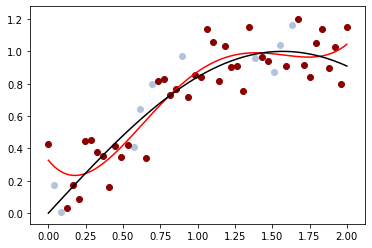

Len  of already  20
Len:  40
Len:  10


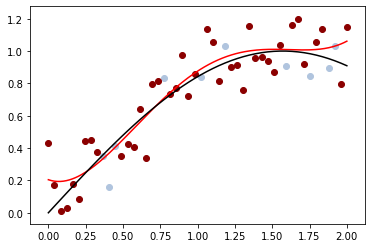

Len  of already  30
Len:  40
Len:  10


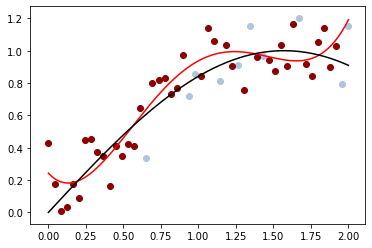

Len  of already  40
Len:  40
Len:  10


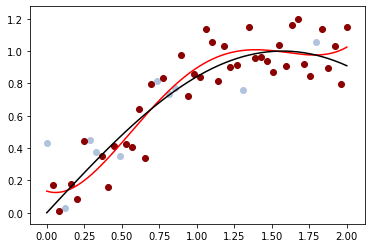

Len  of already  50
Len:  40
Len:  10


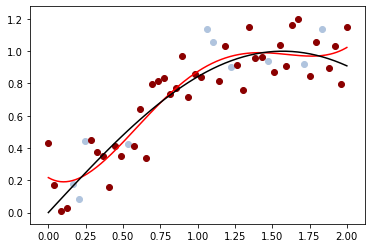

0.7283747748871201

In [16]:
count = 50
X = np.linspace(0, 2, count)
Y = np.sin(X)
X_Y = list(zip(X, Y))
Y_new =[]
for i, val in enumerate(Y):
    Y_new.append(val + np.random.normal(scale = 0.15))
cross_val(X, Y_new, X_Y, frac = 5, degree = 5, pr=True)

# L2

In [17]:
def get_weights_L2(features, y, alpha):
    eye = np.eye(features.shape[1])
    return inv(features.T@features + alpha*eye)@features.T@y

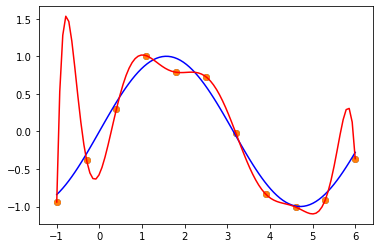

In [20]:
X_of = np.linspace(-1, 6, 11)
Y_of = np.sin(X_of)
Y_new_of =[]
for i, val in enumerate(Y_of):
    Y_new_of.append(val + np.random.normal(scale = 0.15))
plt.scatter(X_of, Y_new_of)

degree = 11
X_test_of = np.linspace(-1, 6, 100)
W_of = get_weights(make_poly_features(polynom, X_of, degree), Y_new_of)
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of), c='blue')
pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='red')
pylab.show()

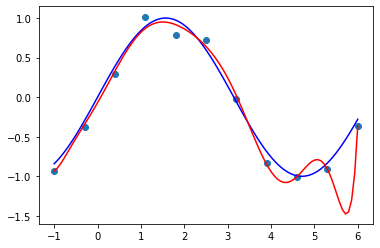

In [21]:
X_test_of = np.linspace(-1, 6, 100)
W_of = get_weights_L2(make_poly_features(polynom, X_of, degree), Y_new_of, alpha=0.05)
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of), c='blue')
pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='red')
pylab.show()

In [22]:
from tqdm import tqdm
count = 150
X = np.linspace(-1, 6, count)
Y = np.sin(X)
degree = 12
X_Y = list(zip(X, Y))

Y_new_of =[]
for i, val in enumerate(Y):
    Y_new_of.append(val + np.random.normal(scale = 0.4))
    
X_train, X_test, y_train, y_test = train_test_split(X, Y_new_of, test_size=1/3)

avg = cross_val(X_train, y_train, y_train, frac = 5, degree=degree,pr=False)
print(avg)

0.5399091643433023


In [23]:
alphas = []
for alpha in tqdm(np.linspace(0.0005, 3, 1000)):
    avg = cross_val(X_train, y_train, X_Y, frac = 2, type_='l2', degree=degree,pr=False, reg=(alpha, ))
    alphas.append(avg)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 552.99it/s]


In [24]:
ar = np.argmax(alphas)
ar

100

In [25]:
(alphas[ar], np.linspace(0.0005, 3, 1000)[ar])

(0.7159221743233419, 0.30075025025025026)

In [26]:
W = get_weights(make_poly_features(polynom, X_train, degree), y_train)
r2_score(y_test, fitted_func(W, X_test, degree))

0.7161991297942236

In [27]:
W_new = get_weights_L2(make_poly_features(polynom, X_train, degree), y_train, 0.2767)
r2_score(y_test, fitted_func(W_new, X_test, degree))

0.7183820940031582

# SVD

In [28]:
def get_weights_SVD(features, y, thr = -100):
    u, s, vh = np.linalg.svd(features, full_matrices=False)
    for ind, val in enumerate(s):
        if abs(val) < thr:
            s[ind] = 0
    features = u@np.diag(s)@vh
    return np.linalg.pinv(features)@y

In [29]:
from tqdm import tqdm
count = 350
X = np.linspace(-1, 6, count)
Y = np.sin(X)
degree = 12
X_Y = list(zip(X, Y))

Y_new_of =[]
for i, val in enumerate(Y):
    Y_new_of.append(val + np.random.normal(scale = 0.45))
    
X_train, X_test, y_train, y_test = train_test_split(X, Y_new_of, test_size=1/3)

avg = 0
t = 100
for _ in tqdm(range(t)):
    avg += cross_val(X_train, y_train, frac = 10, degree=degree)
print(avg/t)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.70it/s]

0.6543342786335704


In [265]:
alphas = []
for alpha in tqdm(np.linspace(0, 5, 10000)):
    avg = cross_val(X_train, y_train, frac = 10, type_='svd', degree=degree, reg=(alpha, ))
    alphas.append(avg)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 89.00it/s]


In [266]:
ar = np.argmax(alphas)
ar

6488

In [267]:
(alphas[ar], np.linspace(0, 5, 10000)[ar])

(0.7017873573432599, 3.2443244324432445)

In [269]:
W = get_weights(make_poly_features(polynom, X_train, degree), y_train)
W_new = get_weights_SVD(make_poly_features(polynom, X_train, degree), y_train, 3.244)
print('SVD: ',r2_score(y_test, fitted_func(W_new, X_test, degree)))
print('without SVD: ',r2_score(y_test, fitted_func(W, X_test, degree)))

SVD:  0.6947556935425522
without SVD:  0.6920499423396637


# Gradient descent

In [30]:
def gradient(X, y, w, lam = 0):
    return 2*X.T@(X@w-y) + lam*np.sign(w)

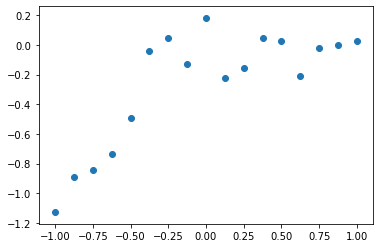

In [31]:
count = 17
degree = 17
X_of = np.linspace(-1, 1, count)
Y_of = np.sin(X_of**3 - X_of**2)
Y_new_of =[]

for i, val in enumerate(Y_of):
    Y_new_of.append(val + np.random.normal(scale = 0.13))
Y_new_of = np.array(Y_new_of)
X = make_poly_features(polynom, X_of, degree)
plt.scatter(X_of, Y_new_of)
# print(*list(zip(X_of, Y_new_of)))

In [32]:
def calc_iter(X, Y_new_of, num, reg=0, type_ = 'gradient', lr_rate = 1e-3):
    w_init = np.random.uniform(-1,1, degree)
    w_old = w_new = w_init
    alpha = lr_rate
    i = 0
    #while True:
    for _ in range(num):
        w_old = w_new
        grad = gradient(X, Y_new_of, w_old, reg)
        w_new = w_old - alpha * grad
        if False:
#        if i%500==0:
            X_test_of = np.linspace(-1, 1, 1000)
            W_of = get_weights(X, Y_new_of)
            pylab.scatter(X_of, Y_new_of)
            pylab.plot(X_test_of, np.sin(X_test_of**3 - X_test_of**2), c='blue')
            pylab.plot(X_test_of, fitted_func(w_new, X_test_of, degree), c='red')
            pylab.show()
        i+=1
#        alpha = alpha/1.0001
    return w_new

In [33]:
def Adam(X, y, theta, lr = 1e-2, beta1 = 0.9, beta2 = 0.9, epsilon = 1e-6, num_iterations = 1000, reg = 0):
    loss = []
    mt = np.zeros(theta.shape[0])
    vt = np.zeros(theta.shape[0])
    for t in range(num_iterations):
        gradients = gradient(X, y, theta, reg)
#         gradients = gradients 
        mt = beta1 * mt + (1. - beta1) * gradients
        vt = beta2 * vt + (1. - beta2) * gradients ** 2
        mt_hat = mt / (1. - beta1 ** (t+1))
        vt_hat = vt / (1. - beta2 ** (t+1))
        theta = theta - (lr / (np.sqrt(vt_hat) + epsilon)) * mt_hat
#         lr = lr /1.05
    return theta

In [34]:
#w_init = np.random.uniform(-1, 1, degree)
w_init = np.array([0 for _ in range(degree)])
w_new = Adam(X, Y_new_of, w_init, num_iterations=100)
w_new

array([-0.03839981,  0.21342258, -0.5933518 ,  0.38753611, -0.23337457,
        0.16407368,  0.01721773,  0.02338468,  0.10837654, -0.03799579,
        0.10707739, -0.06082699,  0.06766284, -0.06603403,  0.02997262,
       -0.06360751,  0.00341539])

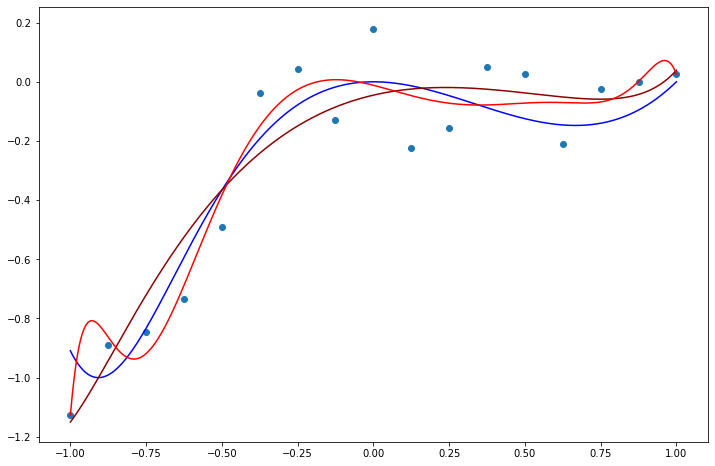

In [35]:
X_test_of = np.linspace(-1, 1, 1000)

# w_new = calc_iter(X, Y_new_of, num= 10000, reg = 0.1, lr_rate=1e-3)
# w_new_without_reg = calc_iter(X, Y_new_of, num= 10000, reg = 0, lr_rate=1e-3)

w_new = Adam(X, Y_new_of, w_init, num_iterations= 1000, reg = 0.1)
w_new_without_reg = Adam(X, Y_new_of, w_init, num_iterations= 1000, reg = 0)

W_of = get_weights(X, Y_new_of)
plt.figure(figsize=(12, 8))
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of**3 - X_test_of**2), c='blue')
pylab.plot(X_test_of, fitted_func(w_new, X_test_of, degree), c='darkred')
pylab.plot(X_test_of, fitted_func(w_new_without_reg, X_test_of, degree), c='red')
#pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='black')
pylab.show()

# L1


In [36]:
from tqdm import tqdm
from copy import copy
count = 300
X = np.linspace(-1, 1, count)
Y = np.sin(X**3 - X**2)
degree = 15
X_Y = list(zip(X, Y))
features = make_poly_features(polynom, X, degree)
w_init = np.array([0 for _ in range(degree)])

Y_new_of =[]
for i, val in enumerate(Y):
    Y_new_of.append(val + np.random.normal(scale = 0.3))
Y_new_of = np.array(Y_new_of)
#     
X_train, X_test, y_train, y_test = train_test_split(X, Y_new_of, test_size=1/3)
X_train_c = copy(X_train)
y_train_c = copy(y_train) 
w_new = Adam(make_poly_features(polynom, X_train, degree), y_train, w_init, 1000, reg = 0.089)

avg = cross_val(X_train, y_train, frac = 10, degree=degree)
print(avg)

0.47121431602204744


Len  of already  40
Len:  160
Len:  40


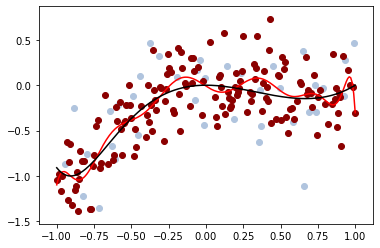

Len  of already  80
Len:  160
Len:  40


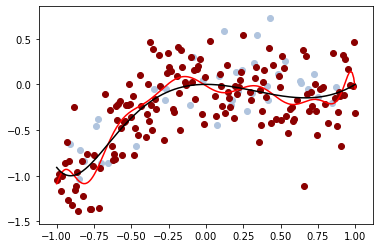

Len  of already  120
Len:  160
Len:  40


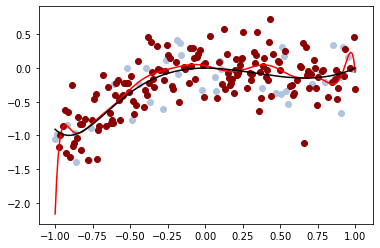

Len  of already  160
Len:  160
Len:  40


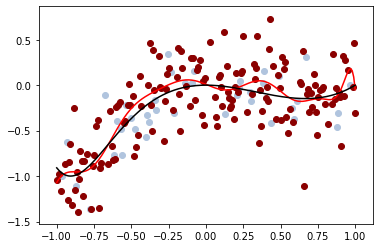

Len  of already  200
Len:  160
Len:  40


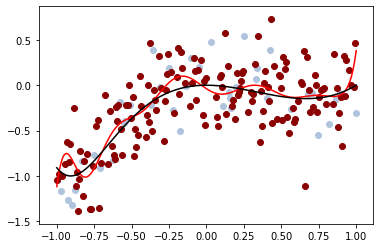

0.45069006729583216

In [37]:
cross_val(X_train, y_train, X_Y, pr = True, frac = 5, degree=degree)

In [38]:
alphas = []
for alpha in tqdm(np.linspace(1e-6, 1, 100)):
    avg = cross_val(X_train, y_train, frac = 10, type_='l1', degree=degree, reg=(1000, alpha))
    alphas.append(avg)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.20it/s]


In [39]:
ar = np.argmax(alphas) 
ar

39

In [322]:
(alphas[ar], np.linspace(1e-6, 1, 100)[ar])

(0.5664293911805363, 0.2727279999999999)

Len  of already  40
Len:  160
Len:  40


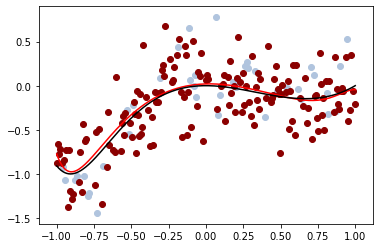

Len  of already  80
Len:  160
Len:  40


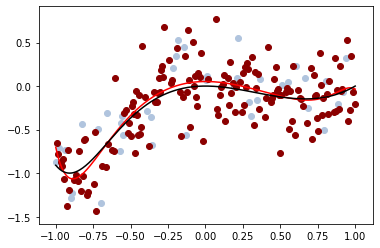

Len  of already  120
Len:  160
Len:  40


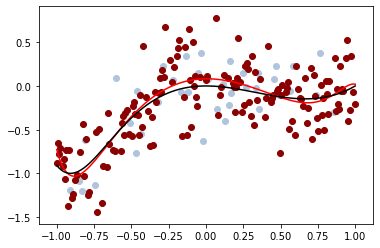

Len  of already  160
Len:  160
Len:  40


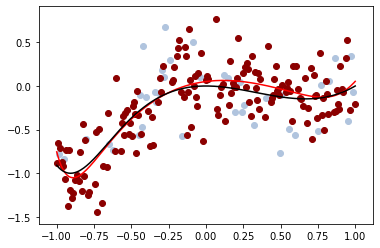

Len  of already  200
Len:  160
Len:  40


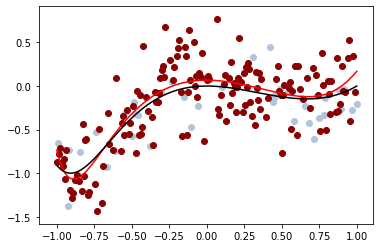

0.5067277542247959

In [323]:
cross_val(X_train, y_train, X_Y, frac = 5, type_='l1', degree=degree,pr=True, reg=(1000, 0.27))

In [341]:
X_temp = make_poly_features(polynom, X_train, degree)
W = get_weights(X_temp, y_train)
W_new = Adam(X_temp, y_train, w_init, 1000, reg = 0.04)
print('L1: ',r2_score(y_test, fitted_func(W_new, X_test, degree)))
print('without L1: ',r2_score(y_test, fitted_func(W, X_test, degree)))

L1:  0.5693917227805834
without L1:  0.534516709444899


# Huber

In [40]:
def huber_gradient_1(feat, X, y, w, param = 1):
    n, m = feat.shape
    absXwy = abs(feat@w-y)
    Xwy = feat@w-y
    Xw = feat@w
    temp_vec = list()
    for ind, val in enumerate(absXwy>=param):
        if val:
            temp_vec.append(Xwy[ind])
        else:
            temp_vec.append(0)
    mat = np.array([temp_vec for _ in range(n)])           
    grad_mat = param*np.sign(mat)@feat
    grad_abs = np.diagonal(grad_mat)
    counter = 0
    vec_qs = []
    for e in range(m):
        temp_vec = list()
        x_z = feat[:, e]
        for ind, val in enumerate(absXwy<param):
            if val:
                temp_vec.append(2*Xwy[ind])
            else:
                temp_vec.append(0)
        vec_qs.append(temp_vec@x_z)
    grad_sq = np.array(vec_qs)
    return grad_abs+grad_sq

(5,)   (5,)


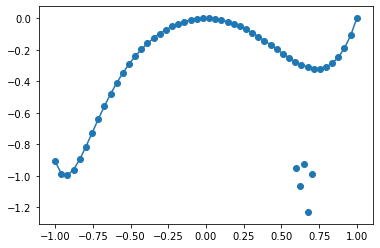

In [41]:
count = 50
degree = 12
noise_num = 5

noise_X = np.linspace(0.6, 0.7, num = noise_num)
noise_Y = np.random.normal(-1, 0.1, size = noise_num)

X_of = np.linspace(-1, 1, count)
Y_of = np.sin(X_of**5 - X_of**2)
X_of_noise = np.array(list(X_of) + list(noise_X))
Y_of_noise = np.array(list(Y_of) + list(noise_Y))
Y_new_of =[]

print(noise_X.shape, ' ', noise_Y.shape)

for i, val in enumerate(Y_of_noise):
    Y_new_of.append(val + np.random.normal(scale = 0.05))
Y_new_of = np.array(Y_new_of)

w_init = np.random.uniform(-10, 10, degree)
feat = make_poly_features(polynom, X_of, degree)

#huber_gradient_1(feat, X_of_noise, Y_new_of, w_init, 0.29)
plt.scatter(X_of_noise, Y_of_noise)
plt.plot(X_of, Y_of)

In [42]:
def calc_iter_huber(feat, X, Y_new_of, num, reg=100, w_init = None, alpha = 1e-2):
    if w_init is None:
        w_init = np.random.uniform(-1,1, degree)
    w_old = w_new = w_init
    alpha = alpha
    i = 0
    #while True:
    for _ in range(num):
        w_old = w_new
        grad = huber_gradient_1(feat, X, Y_new_of, w_old, reg)
        w_new = w_old - alpha * grad
        if False:
#        if i%500==0:
            X_test_of = np.linspace(-1, 1, 1000)
            W_of = get_weights(X, Y_new_of)
            pylab.scatter(X_of, Y_new_of)
            pylab.plot(X_test_of, np.sin(X_test_of**3 - X_test_of**2), c='blue')
            pylab.plot(X_test_of, fitted_func(w_new, X_test_of, degree), c='red')
            pylab.show()
        i+=1
    return w_new

In [43]:
feat = make_poly_features(polynom, X_of_noise, degree)
w_init = calc_iter(feat, Y_new_of, 5)
w = calc_iter_huber(feat, X_of_noise, Y_new_of, 1000, 0.3, np.random.uniform(-3, 3, degree))
W_new = Adam(feat, Y_new_of, w_init, num_iterations=1000)

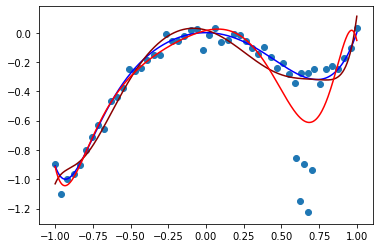

In [44]:
X_test_of = np.linspace(-1, 1, 600)
W_of = get_weights(make_poly_features(polynom, X_of_noise, degree), Y_new_of)
pylab.scatter(X_of_noise, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of**5 - X_test_of**2), c='blue')
pylab.plot(X_test_of, fitted_func(w, X_test_of, degree), c='darkred')
pylab.plot(X_test_of, fitted_func(W_new, X_test_of, degree), c='red')
#pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='black')
pylab.show()

# Spline

In [45]:
X_of = np.linspace(-1, 1, 60)
Y_of = np.sin(X_of**5 - X_of**2)
Y_new_of =[]

for i, val in enumerate(Y_of):
    Y_new_of.append(val + np.random.normal(scale = 0.05))
Y_new_of = np.array(Y_new_of)

In [46]:
def fitted_func_spline(W, X, k, degree, partition = None):
    vec = list()
    for x in X:       
        _sum = 0
        for i in range(degree):
            if i>k:
                if x>=partition[i-k-1]:
                    _sum += W[i]*(pow((x - partition[i-k-1]), k))
            else:
                _sum += W[i]*(pow(x, i))
        vec.append(_sum)
    return vec

In [47]:
def spline_polynom(i, x, k, partition):
    if i>k:
        temp = partition[i-k-1]
        if x >= temp:
            return ((x-temp)**(k))
        else:
            return 0
    else:
        return x**i

In [48]:
def make_spline_features_(fun, X, partition, degree, k):
    features = []
    for ind in range(len(X)):
        temp = []
        for j in range(degree):
#            print(i, j)
            temp.append(fun(j, X[ind], k, partition))
        features.append(temp)
    features = np.array(features)
    return features

In [49]:
def make_spline_features(fun, X, partition, i, k):
    degree = i+k
    features = []
    for ind in range(len(X)):
        temp = []
        for j in range(degree):
#            print(i, j)
            temp.append(fun(j, X[ind], k, partition))
        features.append(temp)
    features = np.array(features)
    return features

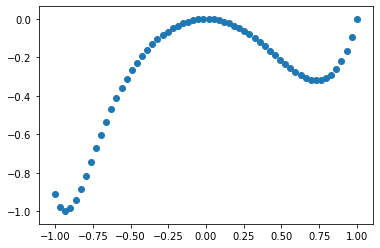

In [54]:
k = 4
i = 5
feat = make_spline_features(spline_polynom, X_of, np.linspace(-1, 1, i) , i, k)

plt.scatter(X_of, Y_of)

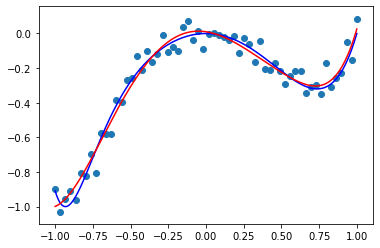

In [55]:
X_test_of = np.linspace(-1, 1, 1000)
W_of = get_weights(feat, Y_new_of)
w_init = np.random.uniform(-3, 3, i+k)
W_new = Adam(feat, Y_new_of, w_init, num_iterations=1000)
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of**5 - X_test_of**2), c='blue')
pylab.plot(X_test_of, fitted_func_spline(W_new, X_test_of, k, i+k, np.linspace(-1, 1, i)), c='red')
pylab.show()

(5,)   (5,)


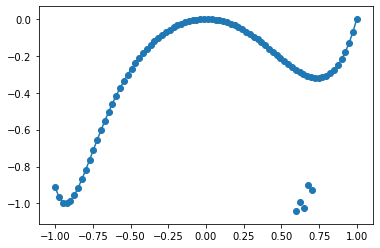

In [56]:
count = 80
k = 5
i = 5
noise_num = 5

noise_X = np.linspace(0.6, 0.7, num = noise_num)
noise_Y = np.random.normal(-1, 0.1, size = noise_num)

X_of = np.linspace(-1, 1, count)
Y_of = np.sin(X_of**5 - X_of**2)
X_of_noise = np.array(list(X_of) + list(noise_X))
Y_of_noise = np.array(list(Y_of) + list(noise_Y))
Y_new_of =[]

print(noise_X.shape, ' ', noise_Y.shape)

for ind, val in enumerate(Y_of_noise):
    Y_new_of.append(val + np.random.normal(scale = 0.05))
Y_new_of = np.array(Y_new_of)
feat = make_spline_features(spline_polynom, X_of_noise, np.linspace(-1, 1, i) , i, k)

#huber_gradient_1(feat, X_of_noise, Y_new_of, w_init, 0.29)
plt.scatter(X_of_noise, Y_of_noise)
plt.plot(X_of, Y_of)

In [57]:
X_test_of = np.linspace(-1, 1, 600)
w_init = np.random.uniform(-0.1, 0.1, k+i)
W_of = calc_iter_huber(feat, X_of_noise, Y_new_of, 10000, 0.4, w_init, alpha = 1e-4)
W_without = calc_iter_huber(feat, X_of_noise, Y_new_of, 10000, 100, w_init, alpha = 1e-4)

pylab.scatter(X_of_noise, Y_new_of)
pylab.plot(X_test_of, np.sin(X_test_of**5 - X_test_of**2), c='blue')
pylab.plot(X_test_of, fitted_func_spline(W_of, X_test_of, k, i+k, np.linspace(-1, 1, i)), c='darkred')
pylab.plot(X_test_of, fitted_func_spline(W_of, X_test_of, k, i+k, np.linspace(-1, 1, i)), c='red')
#pylab.plot(X_test_of, fitted_func(W_of, X_test_of, degree), c='black')
pylab.show()

KeyboardInterrupt: 

# DFT

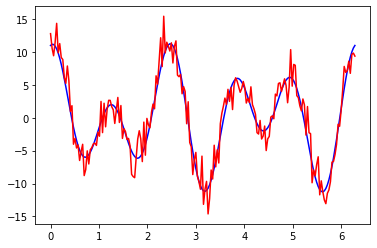

In [589]:
L = 2*np.pi
N = 200
x = np.linspace(0, L, N)
y = 3*np.sin(3*x) + 4*np.cos(3*x) + 7*np.cos(5*x)
y_noise =[]

for i, val in enumerate(y):
    y_noise.append(val + np.random.normal(scale = 2))
y_noise = np.array(y_noise)
pylab.plot(x, y, c='blue')
pylab.plot(x, y_noise, c='red')
pylab.show()

In [590]:
def DFT(x, y):
    a, b = list(), list()
    n = N
    h = L/(n-1)
    for k in range(1, n-1):
        cos_l = np.cos(2*np.pi*k*x/L)*h
        sin_l = np.sin(2*np.pi*k*x/L)*h
        a.append(2/L * (y[:n-1] @ cos_l[:n-1]))
        b.append(2/L * (y[:n-1] @ sin_l[:n-1]))
    a = np.array(a)
    b = np.array(b)
    return a, b, np.sqrt(a**2+b**2)

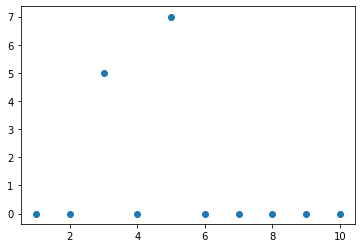

In [591]:
a, b, A = DFT(x, y)
plt.scatter(range(1, n-1)[:10], np.sqrt(a**2 + b**2)[:10])

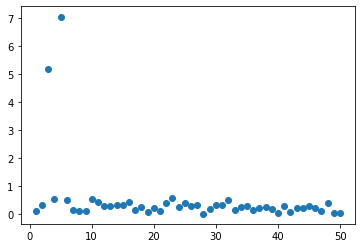

In [592]:
a, b, A = DFT(x, y_noise)
plt.scatter(range(1, n-1)[:50], np.sqrt(a**2 + b**2)[:50])

In [593]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1/4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3)

In [594]:
from sklearn.model_selection import cross_val_score
results = []
a, b, A = DFT(X_train, y_train)
for k in np.linspace(0, np.max(A), 1000):
    ind = list(filter(lambda x: x[1], list(zip(range(0, len(A)), A>k))))
    y_ans = np.zeros(len(X_val))
    for elem, _ in ind:
        y_ans += a[elem]*np.cos(2.* np.pi * (elem + 1) * X_val / L) + b[elem]*np.sin(2.* np.pi * (elem + 1) * X_val / L)
    results.append(r2_score(y_val, y_ans))

In [595]:
np.argmax(results), np.linspace(0, np.max(A), 1000)[np.argmax(results)]

(296, 1.0559701757804811)

In [596]:
sorted(np.unique(A), reverse=True)[:10]

[3.5638993432591235,
 3.563899343259123,
 2.5121280902142824,
 2.512128090214248,
 1.054312153935379,
 1.0543121539353655,
 0.943149884399492,
 0.9431498843994643,
 0.8202863319890781,
 0.8202863319890658]

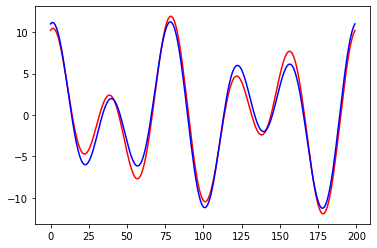

In [601]:
k = np.linspace(0, np.max(A), 1000)[np.argmax(results)]
ind = list(filter(lambda x: x[1], list(zip(range(0, len(A)), A>k))))
y_ans = np.zeros(len(x))
for elem, _ in ind:
    y_ans += a[elem]*np.cos(2.* np.pi * (elem + 1) * x / L) + b[elem]*np.sin(2.* np.pi * (elem + 1) * x / L)
pylab.plot(range(len(y_ans)), y_ans, color = 'red')
pylab.plot(range(len(y)), y, color = 'blue')

# Composite basis

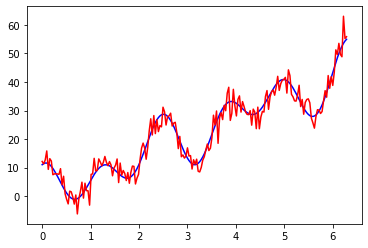

In [584]:
L = 2*np.pi
N = 200
x = np.linspace(0, L, N)
y = 7*x + 3*np.sin(3*x) + 4*np.cos(3*x) + 7*np.cos(5*x)
y_noise =[]

for i, val in enumerate(y):
    y_noise.append(val + np.random.normal(scale = 3))
y_noise = np.array(y_noise)
pylab.plot(x, y, c='blue')
pylab.plot(x, y_noise, c='red')
pylab.show()

In [585]:
def BasicFun(X, deg):
    features = []
    features.append([1 for _ in range(len(X))])
    features.append(X)
    for k in range(1, deg+1):
        features.append(np.cos(2*np.pi*k/L*X))
        features.append(np.sin(2*np.pi*k/L*X))
    features = np.array(features)
    return features.T

In [586]:
deg = 15
w = get_weights(BasicFun(x, deg), y_noise)

In [587]:
m = len(w)
A = np.zeros(deg)
for i in range(deg):
    A[i] = np.sqrt(w[2+2*i]**2 + w[2+2*i+1]**2)

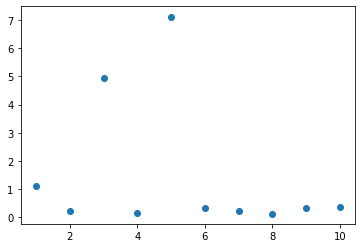

In [588]:
plt.scatter(range(1, deg)[:10], A[:10])

# Nonlinear regression

In [47]:
from scipy.optimize import minimize as opt
from functools import partial

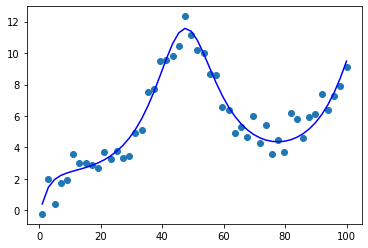

In [48]:
X_of = np.linspace(1, 100, 50)
x = X_of
Y_of = np.log(X_of**3 + np.log(X_of + np.exp(1/X_of)))/(np.sin(X_of/10)+2)
#Y_of = 2*np.exp(-(X_of - 5)**2) + np.exp(-(X_of - 20)**2)
#Y_of = 7*X_of + 3*np.sin(3*X_of) + 4*np.cos(3*X_of) + 7*np.cos(5*X_of)
Y_new_of =[]

for i, val in enumerate(Y_of):
    Y_new_of.append(val + np.random.normal(scale = 0.6))
Y_new_of = np.array(Y_new_of)
X = make_poly_features(polynom, X_of, degree)
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_of, np.log(X_of**3 + np.log(X_of + np.exp(1/X_of)))/(np.sin(X_of/10)+2), c='blue')

In [39]:
k = 5

def normal_d(x, param):
    return np.exp(-(x - param[0])**2 / param[1]**2)
def Q(X, Y, func, params):
    sum_ = 0
    for (x, y) in list(zip(X, Y)):
        temp_sum = 0
        for i in range(k):
            temp_sum += params[i*3]*func(x, params[i*3+1:(i+1)*3]) 
        sum_ += (temp_sum - y)**2
    return sum_
def fitted_func(W_of, X_test_of):
    sum_ = []
    for x in X_test_of:
        temp =0
        for i in range(k):
            (w, a, b) = W_of[i*3:(i+1)*3]
            temp += w*normal_d(x, [a, b])
        sum_.append(temp)
    return sum_

In [40]:
def deriv(param, x):
    der = []
    for i in range(1):
        der.append(np.exp(-((x - param[i*3 + 1])/ param[3*i+2])**2))
        der.append(param[i*3]*2*((x-param[i*3+1])*np.exp(-((x - param[i*3 + 1])/ param[3*i+2])**2)/param[3*i+2]**2))
        der.append(param[i*3]*2*(x-param[i*3+1])**2*np.exp(-((x - param[i*3 + 1])/ param[3*i+2])**2)/param[3*i+2]**3)
    return der
def error_func_deriv(param):
    error_deriv = []
    sum_ = []
    for (x, y) in list(zip(X_of, Y_of)):
        temp_sum = 0
        for i in range(k):
            temp_sum += param[i*3]*normal_d(x, param[i*3+1:(i+1)*3]) 
        sum_.append(temp_sum - y) 
    sum_ = np.array(sum_)
        
    for i in range(k):
        basis_deriv_1 = []
        basis_deriv_2 = []
        basis_deriv_3 = []
        for (x, y) in list(zip(X_of, Y_of)):
            temp = deriv(param[i*3: (i+1)*3], x)
            basis_deriv_1.append(temp[0])
            basis_deriv_2.append(temp[1])
            basis_deriv_3.append(temp[2])
        basis_deriv_1 = np.array(basis_deriv_1)
        basis_deriv_2 = np.array(basis_deriv_2)
        basis_deriv_3 = np.array(basis_deriv_3)
        error_deriv.append(2*np.sum(sum_*basis_deriv_1))
        error_deriv.append(2*np.sum(sum_*basis_deriv_2))
        error_deriv.append(2*np.sum(sum_*basis_deriv_3))
    return np.array(error_deriv)

In [41]:
error_func_deriv(np.random.uniform(2, 20, k*3))

array([ 634.59541229,   10.21049239,   82.05455367,  613.13585327,
         56.08621733,   58.47765484,  482.49007929, -141.64074237,
         83.40289957,  326.04066367,  480.82144394,  462.21475044,
        326.42594477, -166.50393358,  853.33309521])

In [42]:
f = partial(Q, X_of, Y_new_of, normal_d)

## Nelder-Mead

In [46]:
res = opt(f, [(np.random.uniform(1, 10), np.random.uniform(1, 100),
               np.random.uniform(1, 5)) for _ in range(k)], method='Nelder-Mead')

In [47]:
res.x

array([   5.96273763,   47.43414856,  -10.85003646,  233.921042  ,
       -219.13451299,  -16.50303946,    5.61390251,   55.1660623 ,
         47.9664732 ,   15.52705566, -258.3536088 ,   -7.97480933,
          9.254309  ,  106.22564912,   12.48793056])

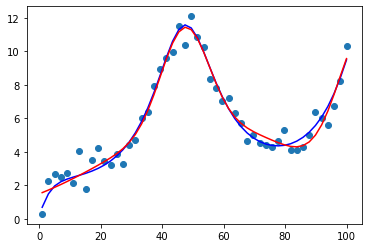

In [48]:
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_of, np.log(X_of**3 + np.log(X_of + np.exp(1/X_of))+2)/(np.sin(X_of/10)+2), c='blue')
pylab.plot(X_of, fitted_func(res.x, X_of), c='red')
#pylab.plot(np.linspace(-1000, 1000, 5000), fitted_func(res.x, np.linspace(-1000, 1000, 5000)), c='red')
pylab.show()

## BFGS

In [49]:
res = opt(f, [(np.random.uniform(1, 10), np.random.uniform(1, 100),
               np.random.uniform(1, 5)) for _ in range(k)], method='BFGS', jac=error_func_deriv)

In [50]:
res.x

array([ 10.13379713,  47.5457775 ,  23.69070001,  16.15976334,
       123.59224793,  31.25878593, -10.46405541,  88.93664649,
        -0.17328453, -12.89941938,  58.63237539,  -0.58764714,
         0.25782838,  81.04780503, -14.07544441])

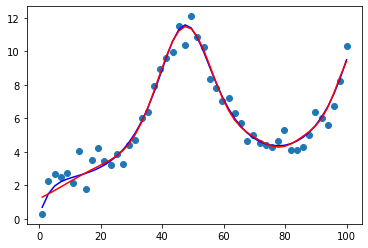

In [58]:
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_of, np.log(X_of**3 + np.log(X_of + np.exp(1/X_of))+2)/(np.sin(X_of/10)+2), c='blue')
pylab.plot(X_of, fitted_func(res.x, X_of), c='red')
#pylab.plot(np.linspace(0, 300, 5000), fitted_func(res.x, np.linspace(0, 300, 5000)), c='red')
pylab.show()

## Newton-CG

In [56]:
res = opt(f, [(np.random.uniform(1, 10), np.random.uniform(1, 100),
               np.random.uniform(1, 5)) for _ in range(k)], method='Newton-CG', jac=error_func_deriv)

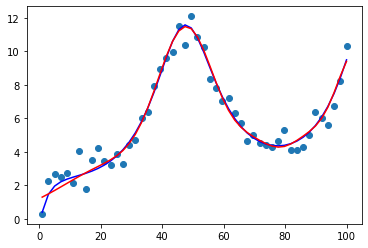

In [57]:
pylab.scatter(X_of, Y_new_of)
pylab.plot(X_of, np.log(X_of**3 + np.log(X_of + np.exp(1/X_of)))/(np.sin(X_of/10)+2), c='blue')
pylab.plot(X_of, fitted_func(res.x, X_of), c='red')
pylab.show()

# EM


In [67]:
from sklearn.mixture import GaussianMixture 
import scipy.stats as sps

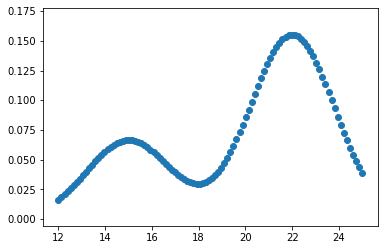

In [68]:
X_of = np.linspace(12, 25, 100)
x = X_of
d1 = sps.norm(15, 1.8)
d2 = sps.norm(22, 1.8)
Y_of = 0.3*d1.pdf(x) + 0.7*d2.pdf(x)

pylab.scatter(X_of, Y_of)

In [70]:
gmm = GaussianMixture (n_components = 2)
gmm.fit(Y_of.reshape(-1, 1))

GaussianMixture(n_components=2)

In [71]:
gmm.weights_, gmm.means_

(array([0.71256328, 0.28743672]),
 array([[0.04943496],
        [0.1306709 ]]))

In [72]:
gmm.predict(Y_of.reshape(-1, 1))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

# Regression. Hypothesis testing

In [3]:
import scipy.stats as sps
from tqdm import tqdm

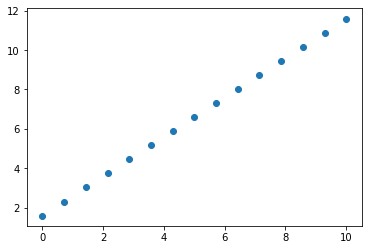

In [46]:
X = np.linspace(0, 10, 15)
Y = 1.6 + X
plt.scatter(X, Y)

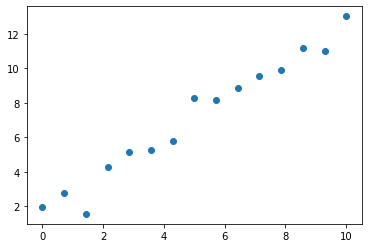

In [47]:
Y_new =[]
for i, val in enumerate(Y):
    Y_new.append(val + np.random.normal(scale = 0.8))
plt.scatter(X, Y_new)

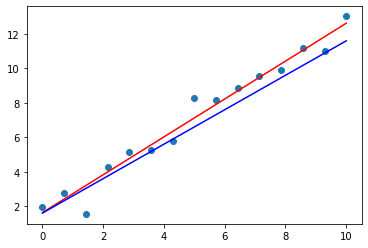

In [48]:
degree=2
X_test = np.linspace(0, 10, 100)
W = get_weights(make_poly_features(polynom, X, degree), Y_new)
pylab.scatter(X, Y_new)
pylab.plot(X_test, fitted_func(W, X_test, degree), c='red')
pylab.plot(X_test, 1.6 + X_test, c='blue')
pylab.show()

In [49]:
W

array([1.62534254, 1.0996436 ])

$$
\widehat{a} \sim N(a, \sigma^2\frac{\sum_{t} X_t^2}{n\sum_{t} x_t^2}) \quad
\widehat{b} \sim N(b, \sigma^2\frac{1}{\sum_{t} x_t^2}) 
\newline x_t = X_t - \bar{X} \quad y_t = Y_t - \bar{Y} \quad \widehat{\sigma}^2 = \frac{\sum_{}(Y_t - \widehat{a} - \widehat{b}X_t)^2}{n-2}
\newline \widehat{b} = \frac{Cov(X, Y)}{Var(X)} \quad \widehat{a} = \bar{Y} - \bar{X}\widehat{b}
$$

In [61]:
a = W[0]
b = W[1]
X_mean = np.sum(X) / len(X)
Y_mean = np.sum(Y_new) / len(Y)
sigma_2 = np.sum((Y_new - a - b*X)**2)/(len(X) -2)
var_a = sigma_2 / (np.sum((X - X_mean)**2))
var_b = sigma_2/(np.sum((X - X_mean)**2))

$$
\frac{\widehat{a} - a}{\sqrt{\sigma^2\frac{\sum_{t} X_t^2}{n\sum_{t} x_t^2}}} \sim N(0, 1) \quad
\frac{\widehat{b} - b}{\sqrt{\sigma^2\frac{1}{\sum_{t} x_t^2}}} \sim N(0, 1) \newline 
\frac{\widehat{\sigma}}{\sigma} \sim \sqrt{\frac{\chi^2(n-2)}{n-2}} \quad => \quad
\frac{\frac{\widehat{b} - b}{\sqrt{\sigma^2\frac{1}{\sum_{t} x_t^2}}}}{\frac{\widehat{\sigma}}{\sigma}}=
\frac{\widehat{b} - b}{\sqrt{\widehat{\sigma}^2\frac{1}{\sum_{t} x_t^2}}} \sim t(n-2)
\newline
\alpha = 0.05 \quad => \quad P(a\in[\widehat{a} - t_{1-\frac{\alpha}{2}}(n-2)\sqrt{\widehat{\sigma}^2\frac{\sum_{t} X_t^2}{n\sum_{t} x_t^2}}, 
\widehat{a} + t_{1-\frac{\alpha}{2}}(n-2)\sqrt{\widehat{\sigma}^2\frac{\sum_{t} X_t^2}{n\sum_{t} x_t^2}}])=0.95 \newline
P(b\in[\widehat{b} - t_{1-\frac{\alpha}{2}}(n-2)\sqrt{\widehat{\sigma}^2\frac{1}{\sum_{t} x_t^2}}, 
\widehat{b} + t_{1-\frac{\alpha}{2}}(n-2)\sqrt{\widehat{\sigma}^2\frac{1}{\sum_{t} x_t^2}}])=0.95
$$

In [62]:
interval_b = (b - 2.16*np.sqrt(var_b), b + 2.16*np.sqrt(var_b))
interval_b

(0.9774386194762734, 1.2218485858394892)

In [63]:
(a - 2.16*np.sqrt(var_a), a + 2.16*np.sqrt(var_a))

(1.5031375588688471, 1.747547525232063)

In [33]:
res = []
for _ in tqdm(range(10000)):
    X = np.linspace(0, 10, 15)
    Y = 1.6 + X
    Y_new =[]
    for i, val in enumerate(Y):
        Y_new.append(val + np.random.normal(scale = 0.8))
    degree=2
    W = get_weights(make_poly_features(polynom, X, degree), Y_new)
    a = W[0]
    b = W[1]
    X_mean = np.sum(X) / len(X)
    Y_mean = np.sum(Y_new) / len(Y)
    sigma_2 = np.sum((Y_new - a - b*X)**2)/(len(X) - 2)
    var_a = sigma_2*(np.sum(X**2) / (len(X)*np.sum((X - X_mean)**2)))
    var_b = sigma_2/(np.sum((X - X_mean)**2))
    if (1>=b - 2.16*np.sqrt(var_b) and 1<=b + 2.16*np.sqrt(var_b)):
        res.append(1)
    else:
        res.append(0)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4052.24it/s]


In [34]:
res = np.array(res)
len(res[res == 1])/len(res)

0.9474

In [22]:
(-2.16, 2.16), b/np.sqrt(var_b)

((-2.16, 2.16), 15.460347640133476)

## Linear system identification

In [407]:
from scipy.integrate import odeint
from scipy.optimize import minimize as opt
from functools import partial

$$
\begin{equation*}
 \begin{cases}
   u' = 3u - 1.5 u^2
   \\
   u(0) = 1
  \end{cases}
\end{equation*} 
\quad => \quad u = \frac{2}{e^{-3x} + 1}
$$

In [408]:
X = np.linspace(-3, 3, 50)
Y = 2/(np.exp(-3*X) + 1) + np.random.normal(scale = 0.1, size = 50)
#Y = 2/(np.exp(-3*X) + 1)

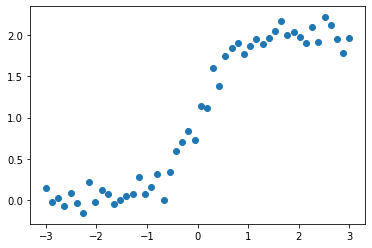

In [409]:
pylab.scatter(X, Y)

In [410]:
2/(np.exp(9) + 1)

0.00024678915197246345

In [411]:
def func(a, b, y, x):
    return a*y - b* (y**2)

def Q(X, Y, func, params):
    sum_ = 0
    t_f = partial(func, *params)
    res = odeint(t_f, 0.00024678915197246345, X)
    for i, y in enumerate(Y):
        sum_ += (res[i][0] - y) ** 2
    return sum_

### Nelder-Mead

In [412]:
f = partial(Q, X, Y, func)
res = opt(f, np.random.uniform(0, 40, 2), method='Nelder-Mead')       

In [413]:
res.x

array([3.00703103, 1.50125775])

### BFGS

In [414]:
def jac(func, X, Y, params):
    sum_ = np.zeros(2)
    t_f = partial(func, *params)
    U_t = odeint(t_f, 0.00024678915197246345, X)
    U_t = U_t[:, 0]
    temp = U_t - Y
    def my_func(y, t):
        r = odeint(t_f, 0.00024678915197246345, [-3, t])[1][0]
        return [
            (params[0] - 2*params[1]*r)*y[0] + r,
            (params[0] - 2*params[1]*r)*y[1] - r**2
        ]
    values = odeint(my_func, [0, 0], X)
    sum_[0] = np.sum(values[:, 0]* temp)
    sum_[1] = np.sum(values[:, 1]* temp)
    return 2*sum_

In [417]:
i = 4
j = 2
jac(func, X, Y, [i, j])

array([ 20.84740107, -15.14692822])

In [418]:
(f([i, j]) - f([i-1e-8, j]))/1e-8, (f([i, j]) - f([i, j-1e-8]))/1e-8

(20.846741755065068, -15.146930820719717)

In [419]:
res = opt(f, np.random.uniform(0, 10, 2), method='BFGS', jac = partial(jac, func, X, Y))

In [420]:
res.x

array([3.00701434, 1.50125834])